In [ ]:
#  EG_T01_MF_eg_09.mp3

In [3]:
#!pip install --upgrade pyannote.audio

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached sentencepiece-0.2.0-cp311-cp311-win_amd64.whl.metadata (8.3 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/898.7 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/898.7 kB ? eta -:--:--
   ---------------------------------------- 898.7/898.7 kB 2.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/811.0 kB ? eta -:--:--
   ---------------------------------------- 811.0/811.0 kB 7.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/807.2 kB ? eta -:--:--
   ---------------------------------------- 807.2/807.2 kB 8.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/869.2 kB ? eta -:--:--
   ---------------------------------------- 869.2/869.2 kB 9.6 MB/s eta 0:00:00
   -------------------------------------

In [9]:
from pyannote.audio import Pipeline
from huggingface_hub import login
from dotenv import dotenv_values
config = dotenv_values(".env")

login(config['HUGGINGFACE_TOKEN'])

diarization_pipeline = Pipeline.from_pretrained('pyannote/speaker-diarization-3.1', use_auth_token=config['HUGGINGFACE_TOKEN']) 

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to C:\Users\grigo\.cache\huggingface\token
Login successful


pytorch_model.bin:   0%|          | 0.00/5.91M [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/399 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/26.6M [00:00<?, ?B/s]

config.yaml:   0%|          | 0.00/221 [00:00<?, ?B/s]

In [11]:
from pyannote.audio.pipelines.utils.hook import ProgressHook

with ProgressHook() as hook:
    diarization = diarization_pipeline('EG_T01_MF_eg_09.mp3', hook=hook)

Output()

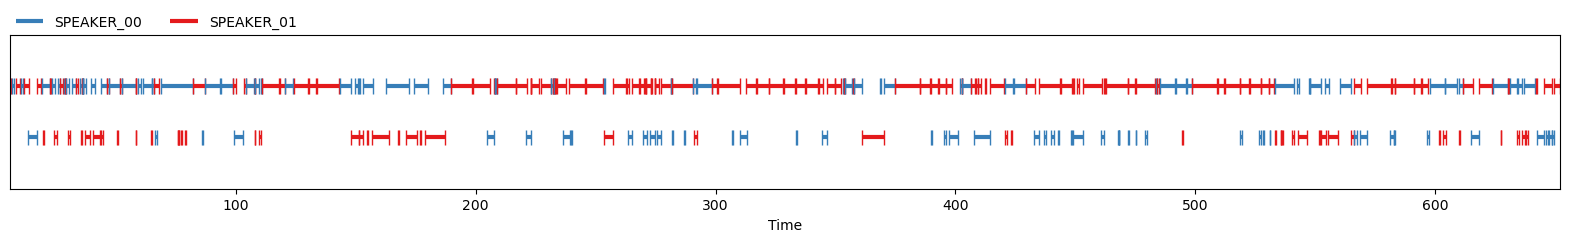

In [12]:
diarization

In [14]:
for turn, _, speaker in diarization.itertracks(yield_label=True):
    print(turn.start)
    print(turn.end)
    print(speaker)
    print('\n\n\n')

5.835968750000001
6.2915937500000005
SPEAKER_01




6.61221875
7.658468750000001
SPEAKER_00




8.14784375
10.03784375
SPEAKER_01




10.240343750000001
11.20221875
SPEAKER_00




11.640968750000003
13.665968750000001
SPEAKER_01




13.193468750000001
17.05784375
SPEAKER_00




17.024093750000002
18.812843750000003
SPEAKER_01




18.981593750000002
22.62659375
SPEAKER_00




19.75784375
20.14596875
SPEAKER_01




22.62659375
23.031593750000003
SPEAKER_01




23.23409375
24.58409375
SPEAKER_00




24.16221875
25.54596875
SPEAKER_01




26.035343750000003
26.86221875
SPEAKER_00




26.86221875
27.891593750000002
SPEAKER_01




28.21221875
28.90409375
SPEAKER_00




28.90409375
29.27534375
SPEAKER_01




29.359718750000003
30.28784375
SPEAKER_00




30.051593750000002
30.92909375
SPEAKER_01




31.55346875
33.190343750000004
SPEAKER_00




33.190343750000004
34.21971875
SPEAKER_01




34.92846875
35.97471875
SPEAKER_00




35.41784375
35.704718750000005
SPEAKER_01




35.97471875
36.19409

In [15]:
def consolidate_speaker_segments(diarization):
    consolidated_segments = []
    current_speaker = None
    segment_start = None
    
    for turn, _, speaker in diarization.itertracks(yield_label=True):
        if speaker != current_speaker:
            if current_speaker is not None:
                consolidated_segments.append((current_speaker, segment_start, turn.start))
            current_speaker = speaker
            segment_start = turn.start
        segment_end = turn.end
        
    if current_speaker is not None:
        consolidated_segments.append((current_speaker, segment_start, turn.start))
        
    return consolidated_segments

In [16]:
segments = consolidate_speaker_segments(diarization)
segments

[('SPEAKER_01', 5.835968750000001, 6.61221875),
 ('SPEAKER_00', 6.61221875, 8.14784375),
 ('SPEAKER_01', 8.14784375, 10.240343750000001),
 ('SPEAKER_00', 10.240343750000001, 11.640968750000003),
 ('SPEAKER_01', 11.640968750000003, 13.193468750000001),
 ('SPEAKER_00', 13.193468750000001, 17.024093750000002),
 ('SPEAKER_01', 17.024093750000002, 18.981593750000002),
 ('SPEAKER_00', 18.981593750000002, 19.75784375),
 ('SPEAKER_01', 19.75784375, 23.23409375),
 ('SPEAKER_00', 23.23409375, 24.16221875),
 ('SPEAKER_01', 24.16221875, 26.035343750000003),
 ('SPEAKER_00', 26.035343750000003, 26.86221875),
 ('SPEAKER_01', 26.86221875, 28.21221875),
 ('SPEAKER_00', 28.21221875, 28.90409375),
 ('SPEAKER_01', 28.90409375, 29.359718750000003),
 ('SPEAKER_00', 29.359718750000003, 30.051593750000002),
 ('SPEAKER_01', 30.051593750000002, 31.55346875),
 ('SPEAKER_00', 31.55346875, 33.190343750000004),
 ('SPEAKER_01', 33.190343750000004, 34.92846875),
 ('SPEAKER_00', 34.92846875, 35.41784375),
 ('SPEAKER_0

In [18]:
!pip install pydub

In [19]:
from pydub import AudioSegment
import os

In [20]:
def split_audio_segments(audio_file, segments, output_dir='segmented_audio'):
    #make sure dir exists
    os.makedirs(output_dir, exist_ok=True)
    #load file
    audio = AudioSegment.from_file(audio_file)
    #iterate over segments and export each one
    for idx, (speaker, start, end) in enumerate(segments):
        start_ms = start * 1000
        end_ms = end * 1000
        #extract segment
        segment = audio[start_ms:end_ms]
        
        speaker_label = speaker.split('_')[-1] # get speaker identifier
        output_file = os.path.join(output_dir, f"{idx:02d}_SPEAKER{speaker_label}_START{start:.0f}_STOP{end:.0f}.mp3")
        
        segment.export(output_file, format="mp3")
        print(f"Exported {output_file}")
        

In [21]:
split_audio_segments('EG_T01_MF_eg_09.mp3', segments)

Exported segmented_audio\00_SPEAKER01_START6_STOP7.mp3
Exported segmented_audio\01_SPEAKER00_START7_STOP8.mp3
Exported segmented_audio\02_SPEAKER01_START8_STOP10.mp3
Exported segmented_audio\03_SPEAKER00_START10_STOP12.mp3
Exported segmented_audio\04_SPEAKER01_START12_STOP13.mp3
Exported segmented_audio\05_SPEAKER00_START13_STOP17.mp3
Exported segmented_audio\06_SPEAKER01_START17_STOP19.mp3
Exported segmented_audio\07_SPEAKER00_START19_STOP20.mp3
Exported segmented_audio\08_SPEAKER01_START20_STOP23.mp3
Exported segmented_audio\09_SPEAKER00_START23_STOP24.mp3
Exported segmented_audio\10_SPEAKER01_START24_STOP26.mp3
Exported segmented_audio\11_SPEAKER00_START26_STOP27.mp3
Exported segmented_audio\12_SPEAKER01_START27_STOP28.mp3
Exported segmented_audio\13_SPEAKER00_START28_STOP29.mp3
Exported segmented_audio\14_SPEAKER01_START29_STOP29.mp3
Exported segmented_audio\15_SPEAKER00_START29_STOP30.mp3
Exported segmented_audio\16_SPEAKER01_START30_STOP32.mp3
Exported segmented_audio\17_SPEAKER0

In [ ]:
# facebook/wav2vec2-base-960h

In [23]:
!pip install tf-keras

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------------ --------------------------- 0.5/1.7 MB 1.9 MB/s eta 0:00:01
   ------------------ --------------------- 0.8/1.7 MB 1.4 MB/s eta 0:00:01
   ------------------------------ --------- 1.3/1.7 MB 2.0 MB/s eta 0:00:01
   ------------------------------------ --- 1.6/1.7 MB 2.1 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 1.5 MB/s eta 0:00:00


In [24]:
from transformers import pipeline
pipe = pipeline('automatic-speech-recognition')

No model was supplied, defaulted to facebook/wav2vec2-base-960h and revision 55bb623 (https://huggingface.co/facebook/wav2vec2-base-960h).
Using a pipeline without specifying a model name and revision in production is not recommended.


model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You sho

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

In [26]:
def process_segmented_files(directory='segmented_audio'):
    if not os.path.exists(directory):
        raise FileNotFoundError(f'{directory} does not exist')
    
    files = os.listdir(directory)
    
    for file in files:
        file_path = os.path.join(directory, file)
        if os.path.isfile(file_path):
            text = pipe(file_path)['text']
            num,speaker,time_start,time_stop = file.split('_')
            time_stop = time_stop.replace('mp3', '')
            print(f"{speaker}-- {time_start}sec {time_stop}sec:\n{text}")
            print('\n\n')
            

In [27]:
process_segmented_files()

SPEAKER01-- START6sec STOP7.sec:
ALONE



SPEAKER00-- START7sec STOP8.sec:
A LITTLE MAT YE



SPEAKER01-- START8sec STOP10.sec:
AYAN A AND A ADYA MIN MAYA



SPEAKER00-- START10sec STOP12.sec:
ANATO ANAHMAD



SPEAKER01-- START12sec STOP13.sec:
MADAME MOSELLEN IS AT



SPEAKER00-- START13sec STOP17.sec:
MTIFAIN AND IM MAIL A TOSSEL BICK IF HE'LL BE IT MA HANDISH BE ROD



SPEAKER01-- START17sec STOP19.sec:
LE ANEMY FOL BET HAT YE ARE



SPEAKER00-- START19sec STOP20.sec:
BE



SPEAKER01-- START20sec STOP23.sec:
DONEOUT I THINK IT OUGHT TO GOT UP IN E MERTIL MAHON



SPEAKER00-- START23sec STOP24.sec:
MANENTIPEE



SPEAKER01-- START357sec STOP358.sec:
RABON



SPEAKER00-- START358sec STOP361.sec:
RIANI MONCEN LOHADORTA SENEC FINA



SPEAKER01-- START361sec STOP369.sec:
COME ON DOWN WHEN A KEBIRBASHOR MONSIEUR BELL AMAZE MY EY HAD TE SHORT MANCHEGIARAFEDRIA BATTLE BAHAREL MONTLAHAD ON BE HER NEG



SPEAKER00-- START369sec STOP375.sec:
AMEN HAV GOT AWAY AND TE HIBLGOTZE GIDONOHIBOTOTEGALL

ValueError: Soundfile is either not in the correct format or is malformed. Ensure that the soundfile has a valid audio file extension (e.g. wav, flac or mp3) and is not corrupted. If reading from a remote URL, ensure that the URL is the full address to **download** the audio file.

In [ ]:
#  jonatasgrosman/wav2vec2-large-xlsr-53-arabic 

In [29]:
from transformers import pipeline
pipe2 = pipeline('automatic-speech-recognition', model='jonatasgrosman/wav2vec2-large-xlsr-53-arabic')

def process_segmented_files_arabic(directory='segmented_audio'):
    if not os.path.exists(directory):
        raise FileNotFoundError(f'{directory} does not exist')
    
    files = os.listdir(directory)
    
    for file in files:
        file_path = os.path.join(directory, file)
        if os.path.isfile(file_path):
            text = pipe2(file_path)['text']
            num,speaker,time_start,time_stop = file.split('_')
            time_stop = time_stop.replace('mp3', '')
            print(f"{speaker}-- {time_start}sec {time_stop}sec:\n{text}")
            print('\n\n')
            

Some weights of the model checkpoint at jonatasgrosman/wav2vec2-large-xlsr-53-arabic were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at jonatasgrosman/wav2vec2-large-xlsr-53-arabic and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You

In [30]:
process_segmented_files_arabic()

SPEAKER01-- START6sec STOP7.sec:
ألوم



SPEAKER00-- START7sec STOP8.sec:
ألو مهيا



SPEAKER01-- START8sec STOP10.sec:
أيونا أنا نادي من ماية



SPEAKER00-- START10sec STOP12.sec:
أنا أن حمد



SPEAKER01-- START12sec STOP13.sec:
أحمد أهل ساهلاً لدغي



SPEAKER00-- START13sec STOP17.sec:
ماعتفيين نعما يلى اتصل بيكي في لبيت محدش بيرود



SPEAKER01-- START17sec STOP19.sec:
لا أنمس ف البتحئيئا



SPEAKER00-- START19sec STOP20.sec:
مِشفي لبي



SPEAKER01-- START20sec STOP23.sec:
لتناء لتعشنكر وتغر بن امرت المحمول



SPEAKER00-- START23sec STOP24.sec:
مَرِانْتِ فرِيهِينَ



SPEAKER01-- START357sec STOP358.sec:
طبان



SPEAKER00-- START358sec STOP361.sec:
يممكن لحد يقت سنك فيهميا



SPEAKER01-- START361sec STOP369.sec:
من دعن ون كبير بعة إلشرم شيخ بي لما يسمع أي حد الشرب الشخيار في الرياضات البحرير الموك الوحد أنبها ماك



SPEAKER00-- START369sec STOP375.sec:
من الغدوي- أن حب الغتس جدةً نحب ت فرك على الأسماك الملونع تحت اللله



SPEAKER01-- START375sec STOP390.sec:
طبعن مشهور غدا بل شعب المر

ValueError: Soundfile is either not in the correct format or is malformed. Ensure that the soundfile has a valid audio file extension (e.g. wav, flac or mp3) and is not corrupted. If reading from a remote URL, ensure that the URL is the full address to **download** the audio file.